# Predicting Titanic Survivors

## Description

![alt text](http://upload.wikimedia.org/wikipedia/commons/6/6e/St%C3%B6wer_Titanic.jpg)

The sinking of the RMS Titanic is one of the most infamous shipwrecks in history.  On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.

One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

In this case study, we will complete the analysis of what sorts of people were likely to survive. In particular, we will apply the tools of machine learning to predict which passengers survived the tragedy.

## Evaluation

The historical data has been split into two groups, a 'training set' and a 'test set'. We use this set to build our model to generate predictions for the test set.

For each passenger in the test set, we must predict whether or not they survived the sinking ( 0 for deceased, 1 for survived ).  

## Data Set

<pre>
VARIABLE DESCRIPTIONS:
survival        Survival
                (0 = No; 1 = Yes)
pclass          Passenger Class
                (1 = 1st; 2 = 2nd; 3 = 3rd)
name            Name
sex             Sex
age             Age
sibsp           Number of Siblings/Spouses Aboard
parch           Number of Parents/Children Aboard
ticket          Ticket Number
fare            Passenger Fare
cabin           Cabin
embarked        Port of Embarkation
                (C = Cherbourg; Q = Queenstown; S = Southampton)

SPECIAL NOTES:
Pclass is a proxy for socio-economic status (SES)
 1st ~ Upper; 2nd ~ Middle; 3rd ~ Lower

Age is in Years; Fractional if Age less than One (1)
 If the Age is Estimated, it is in the form xx.5

With respect to the family relation variables (i.e. sibsp and parch)
some relations were ignored.  The following are the definitions used
for sibsp and parch.

Sibling:  Brother, Sister, Stepbrother, or Stepsister of Passenger Aboard Titanic
Spouse:   Husband or Wife of Passenger Aboard Titanic (Mistresses and Fiances Ignored)
Parent:   Mother or Father of Passenger Aboard Titanic
Child:    Son, Daughter, Stepson, or Stepdaughter of Passenger Aboard Titanic

Other family relatives excluded from this study include cousins,
nephews/nieces, aunts/uncles, and in-laws.  Some children travelled
only with a nanny, therefore parch=0 for them.  As well, some
travelled with very close friends or neighbors in a village, however,
the definitions do not support such relations.
</pre>

### Helper function

You might find the function useful to get quick analysis of the content of the Pandas dataframe.
Pandas functions (for example `describe`) work best with numerical variables, and while below function will help with all types of variables.
Try to play with the functiona and understand how it works.

In [1]:
import pandas as pd
def describe_more(df,normalize_ind=False, weight_column=None, skip_columns=[], dropna=True):
    var = [] ; l = [] ; t = []; unq =[]; min_l = []; max_l = [];
    assert isinstance(skip_columns, list), "Argument skip_columns should be list"
    if weight_column is not None:
        if weight_column not in list(df.columns):
            raise AssertionError('weight_column is not a valid column name in the input DataFrame')
      
    for x in df:
        if x in skip_columns:
            pass
        else:
            var.append( x )
            uniq_counts = len(pd.value_counts(df[x],dropna=dropna))
            uniq_counts = len(pd.value_counts(df[x], dropna=dropna)[pd.value_counts(df[x],dropna=dropna)>0])
            l.append(uniq_counts)
            t.append( df[ x ].dtypes )
            min_l.append(df[x].apply(str).str.len().min())
            max_l.append(df[x].apply(str).str.len().max())
            if weight_column is not None and x not in skip_columns:
                df2 = df.groupby(x).agg({weight_column: 'sum'}).sort_values(weight_column, ascending=False)
                df2['authtrans_vts_cnt']=((df2[weight_column])/df2[weight_column].sum()).round(2)
                unq.append(df2.head(n=100).to_dict()[weight_column])
            else:
                df_cat_d = df[x].value_counts(normalize=normalize_ind,dropna=dropna).round(decimals=2)
                df_cat_d = df_cat_d[df_cat_d>0]
                #unq.append(df[x].value_counts().iloc[0:100].to_dict())
                unq.append(df_cat_d.iloc[0:100].to_dict())
            
    levels = pd.DataFrame( { 'A_Variable' : var , 'Levels' : l , 'Datatype' : t ,
                             'Min Length' : min_l,
                             'Max Length': max_l,
                             'Level_Values' : unq} )
    #levels.sort_values( by = 'Levels' , inplace = True )
    return levels

## Setup Imports and Variables

In [2]:
import pandas as pd
import numpy as np
import pylab as plt

# Set the global default size of matplotlib figures
plt.rc('figure', figsize=(10, 5))

# Size of matplotlib figures that contain subplots
fizsize_with_subplots = (10, 10)

# Size of matplotlib histogram bins
bin_size = 10

## Explore the Data

Read the data:

In [3]:
df_train = pd.read_csv('train.csv')
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
df_train.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


View the data types of each column:

In [5]:
df_train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

Type 'object' is a string for pandas, which poses problems with machine learning algorithms.  If we want to use these as features, we'll need to convert these to number representations.

Get some basic information on the DataFrame:

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Age, Cabin, and Embarked are missing values.  Cabin has too many missing values, whereas we might be able to infer values for Age and Embarked.

Generate various descriptive statistics on the DataFrame:

In [7]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


We will utilize `describe_more` function to get more insights into Train dataset.

In [8]:
pd.options.display.max_colwidth = 100
desc_df = describe_more(df_train)
desc_df

,A_Variable,Levels,Datatype,Min Length,Max Length,Level_Values
0,PassengerId,891,int64,1,3,"{1: 1, 599: 1, 588: 1, 589: 1, 590: 1, 591: 1, 592: 1, 593: 1, 594: 1, 595: 1, 596: 1, 597: 1, 5..."
1,Survived,2,int64,1,1,"{0: 549, 1: 342}"
2,Pclass,3,int64,1,1,"{3: 491, 1: 216, 2: 184}"
3,Name,891,object,12,82,"{'Braund, Mr. Owen Harris': 1, 'Boulos, Mr. Hanna': 1, 'Frolicher-Stehli, Mr. Maxmillian': 1, 'G..."
4,Sex,2,object,4,6,"{'male': 577, 'female': 314}"
5,Age,88,float64,3,4,"{24.0: 30, 22.0: 27, 18.0: 26, 19.0: 25, 28.0: 25, 30.0: 25, 21.0: 24, 25.0: 23, 36.0: 22, 29.0:..."
6,SibSp,7,int64,1,1,"{0: 608, 1: 209, 2: 28, 4: 18, 3: 16, 8: 7, 5: 5}"
7,Parch,7,int64,1,1,"{0: 678, 1: 118, 2: 80, 5: 5, 3: 5, 4: 4, 6: 1}"
8,Ticket,681,object,3,18,"{'347082': 7, 'CA. 2343': 7, '1601': 7, '3101295': 6, 'CA 2144': 6, '347088': 6, 'S.O.C. 14879':..."
9,Fare,248,float64,3,8,"{8.05: 43, 13.0: 42, 7.8958: 38, 7.75: 34, 26.0: 31, 10.5: 24, 7.925: 18, 7.775: 16, 7.2292: 15,..."


Now that we have a general idea of the data set contents, we can dive deeper into each column.  We'll be doing exploratory data analysis and cleaning data to setup 'features' we'll be using in our machine learning algorithms.

Plot a few features to get a better idea of each:

Text(0.5, 1.0, 'Age Histogram')

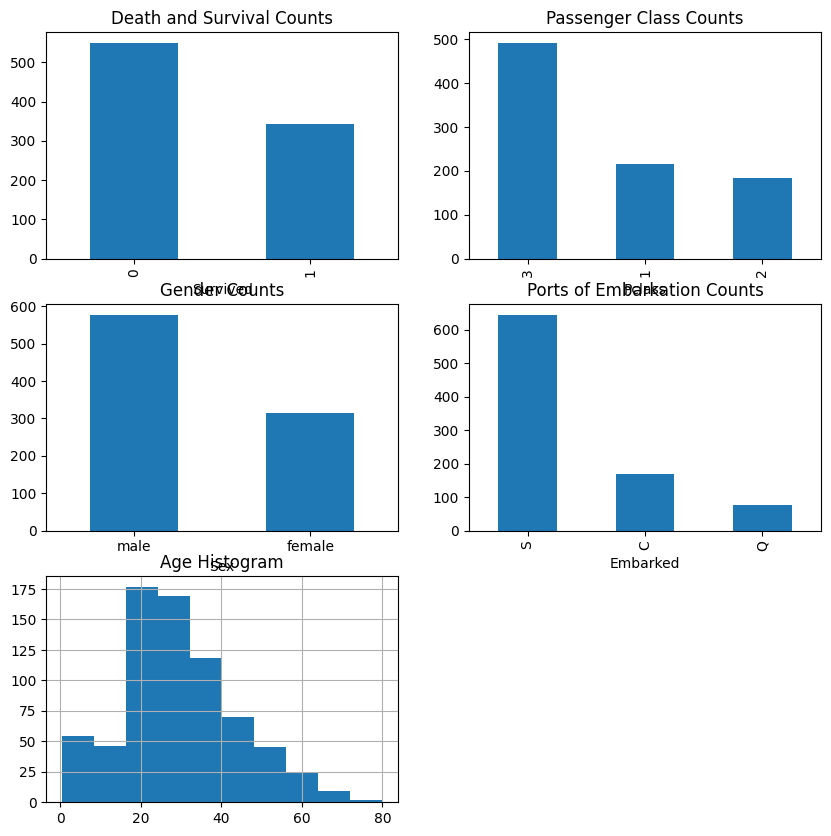

In [9]:
# Set up a grid of plots
fig = plt.figure(figsize=fizsize_with_subplots) 
fig_dims = (3, 2)

# Plot death and survival counts
plt.subplot2grid(fig_dims, (0, 0))
df_train['Survived'].value_counts().plot(kind='bar', 
                                         title='Death and Survival Counts')

# Plot Pclass counts
plt.subplot2grid(fig_dims, (0, 1))
df_train['Pclass'].value_counts().plot(kind='bar', 
                                       title='Passenger Class Counts')

# Plot Sex counts
plt.subplot2grid(fig_dims, (1, 0))
df_train['Sex'].value_counts().plot(kind='bar', 
                                    title='Gender Counts')
plt.xticks(rotation=0)

# Plot Embarked counts
plt.subplot2grid(fig_dims, (1, 1))
df_train['Embarked'].value_counts().plot(kind='bar', 
                                         title='Ports of Embarkation Counts')

# Plot the Age histogram
plt.subplot2grid(fig_dims, (2, 0))
df_train['Age'].hist()
plt.title('Age Histogram')

Next we'll explore various features to view their impact on survival rates.

## Feature: Passenger Classes

From our exploratory data analysis in the previous section, we see there are three passenger classes: First, Second, and Third class.  We'll determine which proportion of passengers survived based on their passenger class.

Generate a cross tab of Pclass and Survived:

In [10]:
pclass_xt = pd.crosstab(df_train['Pclass'], df_train['Survived'])
pclass_xt

Survived,0,1
Pclass,,
1,80,136
2,97,87
3,372,119


Plot the cross tab:

Text(0, 0.5, 'Survival Rate')

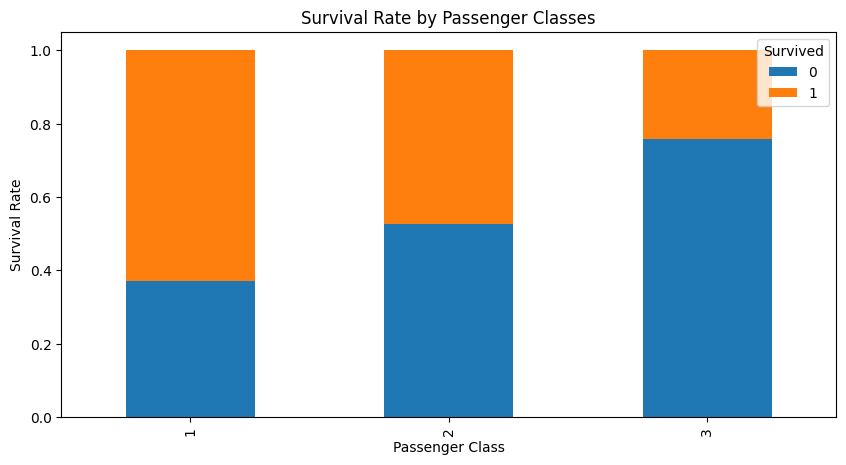

In [11]:
# Normalize the cross tab to sum to 1:
pclass_xt_pct = pclass_xt.div(pclass_xt.sum(1).astype(float), axis=0)

pclass_xt_pct.plot(kind='bar', 
                   stacked=True, 
                   title='Survival Rate by Passenger Classes')
plt.xlabel('Passenger Class')
plt.ylabel('Survival Rate')

We can see that passenger class seems to have a significant impact on whether a passenger survived.  Those in First Class the highest chance for survival.

## Feature: Sex

Gender might have also played a role in determining a passenger's survival rate.  We'll need to map Sex from a string to a number to prepare it for machine learning algorithms.

<Axes: title={'center': 'Survival Rate by Gender'}, xlabel='Sex'>

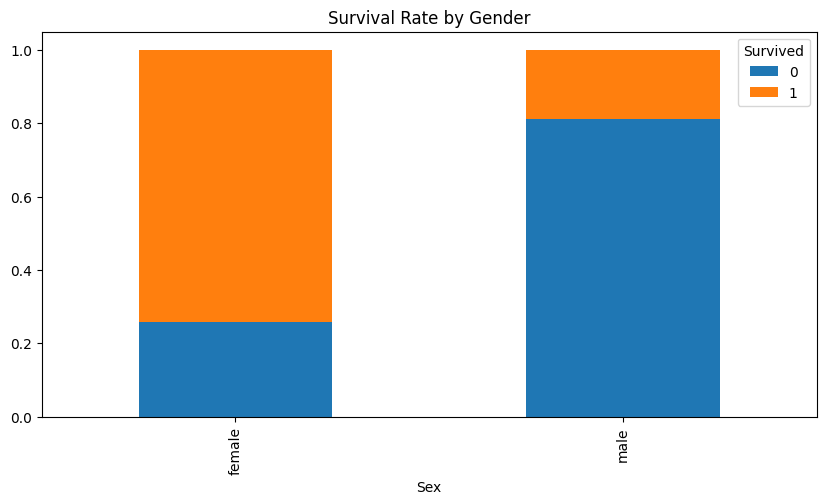

In [12]:
sex_val_xt = pd.crosstab(df_train['Sex'], df_train['Survived'])
sex_val_xt_pct = sex_val_xt.div(sex_val_xt.sum(1).astype(float), axis=0)
sex_val_xt_pct.plot(kind='bar', stacked=True, title='Survival Rate by Gender')

The majority of females survived, whereas the majority of males did not.

Next we'll determine whether we can gain any insights on survival rate by looking at both Sex and Pclass.

Count males and females in each Pclass:

In [13]:
# Get the unique values of Pclass:
passenger_classes = sorted(df_train['Pclass'].unique())

for p_class in passenger_classes:
    print('M: ', p_class, len(df_train[(df_train['Sex'] == 'male') & 
                             (df_train['Pclass'] == p_class)]))
    print('F: ', p_class, len(df_train[(df_train['Sex'] == 'female') & 
                             (df_train['Pclass'] == p_class)]))

M:  1 122
F:  1 94
M:  2 108
F:  2 76
M:  3 347
F:  3 144


Plot survival rate by Sex and Pclass:

Text(0, 0.5, 'Survival Rate')

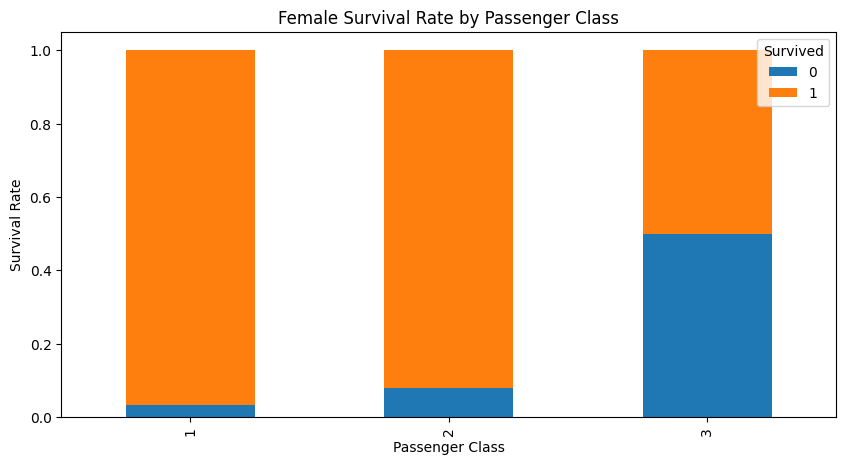

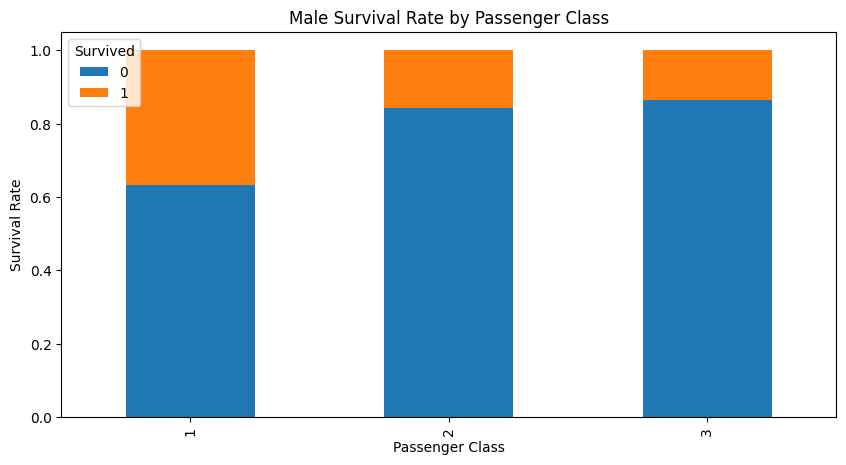

In [14]:
# Plot survival rate by Sex
females_df = df_train[df_train['Sex'] == 'female']
females_xt = pd.crosstab(females_df['Pclass'], df_train['Survived'])
females_xt_pct = females_xt.div(females_xt.sum(1).astype(float), axis=0)
females_xt_pct.plot(kind='bar', 
                    stacked=True, 
                    title='Female Survival Rate by Passenger Class')
plt.xlabel('Passenger Class')
plt.ylabel('Survival Rate')

# Plot survival rate by Pclass
males_df = df_train[df_train['Sex'] == 'male']
males_xt = pd.crosstab(males_df['Pclass'], df_train['Survived'])
males_xt_pct = males_xt.div(males_xt.sum(1).astype(float), axis=0)
males_xt_pct.plot(kind='bar', 
                  stacked=True, 
                  title='Male Survival Rate by Passenger Class')
plt.xlabel('Passenger Class')
plt.ylabel('Survival Rate')

The vast majority of females in First and Second class survived.  Males in First class had the highest chance for survival.

## Feature: Embarked

The Embarked column might be an important feature but it is missing a couple data points which might pose a problem for machine learning algorithms:

In [15]:
df_train[df_train['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [16]:
df_train['Embarked'].unique()

array(['S', 'C', 'Q', nan], dtype=object)

<Axes: title={'center': 'Port of Embarkation Histogram'}, xlabel='Embarked'>

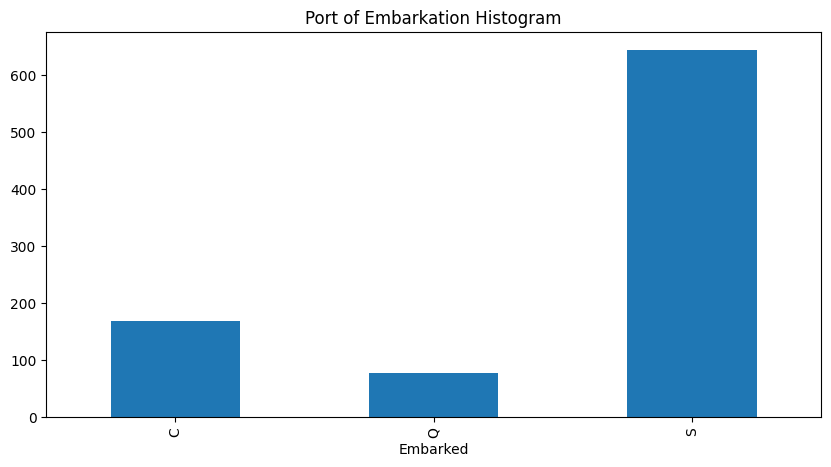

In [17]:
df_train.groupby('Embarked').count()['PassengerId'].plot(kind = 'bar',  
                                                         title = 'Port of Embarkation Histogram')

Since the vast majority of passengers embarked in 'S': 3, we assign the missing values in Embarked to 'S': 

In [18]:
df_train['Embarked'].replace(np.NaN, 'S',inplace = True)

Verify we do not have any more NaNs for Embarked:

In [19]:
df_train['Embarked'].unique()

array(['S', 'C', 'Q'], dtype=object)

Plot a normalized cross tab for Embarked and Survived:

<Axes: xlabel='Embarked'>

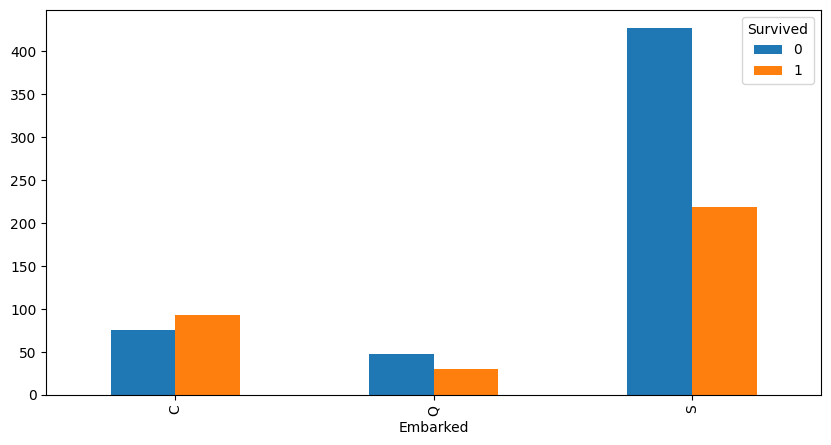

In [20]:
pd.crosstab(df_train['Embarked'], df_train['Survived']).plot(kind = 'bar')

It appears those that embarked in location 'C': 1 had the highest rate of survival.  We'll dig in some more to see why this might be the case.  Below we plot a graphs to determine gender and passenger class makeup for each port:

<Axes: xlabel='Embarked'>

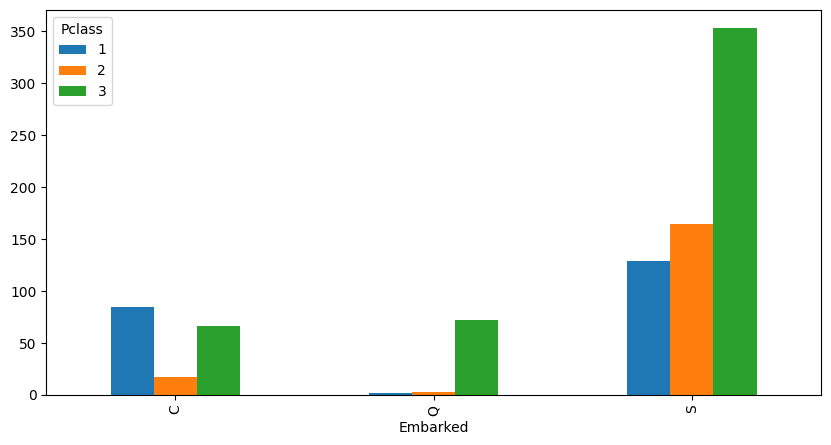

In [21]:
pd.crosstab(df_train['Embarked'], df_train['Pclass']).plot(kind = 'bar')

## Feature: Age

The Age column seems like an important feature--unfortunately it is missing many values.  We'll need to fill in the missing values like we did with Embarked.

Filter to view missing Age values:

In [22]:
df_train[df_train['Age'].isnull()][['Sex', 'Pclass', 'Age']].head()

,Sex,Pclass,Age
5,male,3,NaN
17,male,2,NaN
19,female,3,NaN
26,male,3,NaN
28,female,3,NaN


Determine the Age typical for each passenger class by Sex.  We'll use the median instead of the mean because the Age histogram seems to be right skewed.

In [23]:
df_train[['Age', 'Sex']].groupby('Sex').median()

,Age
Sex,
female,27.0
male,29.0


In [24]:
df_train[['Age', 'Pclass']].groupby('Pclass').median()

,Age
Pclass,
1,37.0
2,29.0
3,24.0


Text(0, 0.5, 'Count')

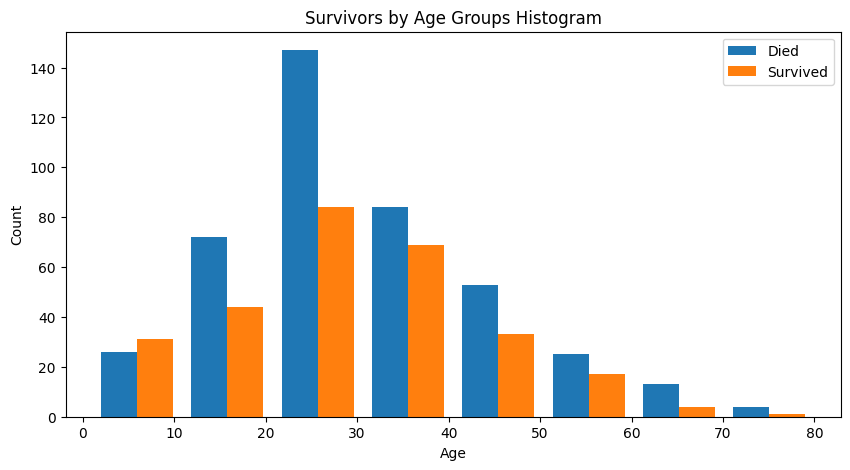

In [25]:
df1 = df_train[df_train['Survived'] == 0]['Age']
df2 = df_train[df_train['Survived'] == 1]['Age']

plt.hist([df1, df2], bins= 8, range=(1, 80))
plt.legend(('Died', 'Survived'), loc='best')
plt.title('Survivors by Age Groups Histogram')
plt.xlabel('Age')
plt.ylabel('Count')

Unfortunately, the graphs above do not seem to clearly show any insights.  We'll keep digging further.

Plot Age density by Pclass:

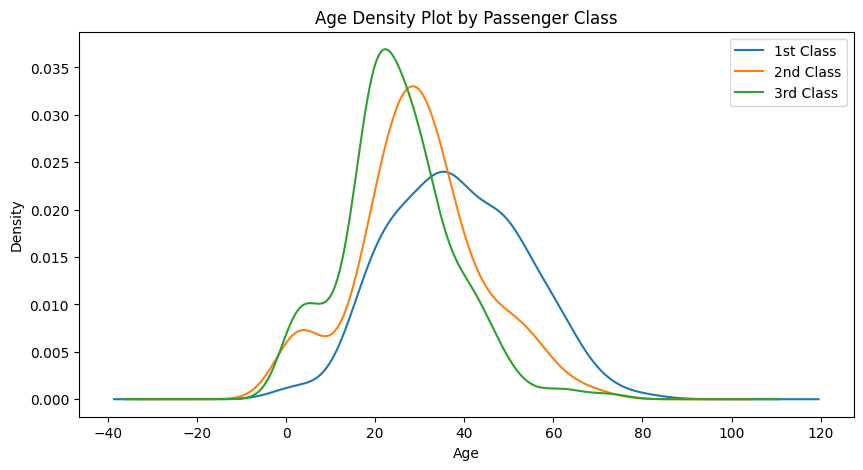

In [26]:
for pclass in passenger_classes:
    df_train.Age[df_train.Pclass == pclass].plot(kind='kde')
    
plt.title('Age Density Plot by Passenger Class')
plt.xlabel('Age')
plt.legend(('1st Class', '2nd Class', '3rd Class'), loc='best')

When looking at Age density by Pclass, we see the first class passengers were generally older then second class passengers, which in turn were older than third class passengers.  We've determined that first class passengers had a higher survival rate than second class passengers, which in turn had a higher survival rate than third class passengers.

<Axes: >

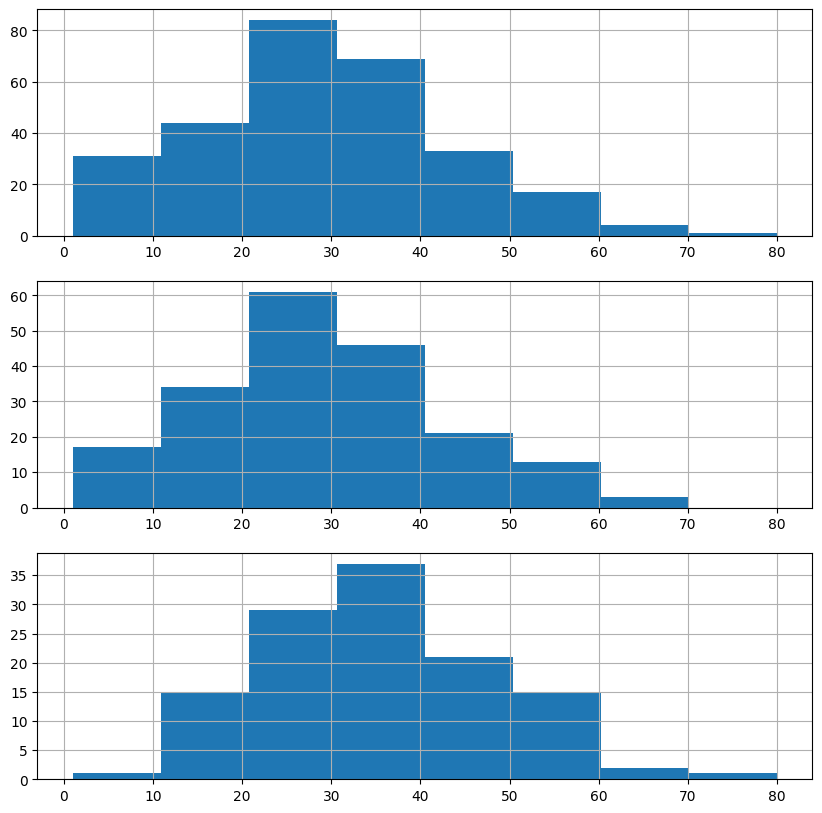

In [27]:
# Set up a grid of plots
fig = plt.figure(figsize=fizsize_with_subplots) 
fig_dims = (3, 1)

# Plot the Age histogram for Survivors
plt.subplot2grid(fig_dims, (0, 0))
survived_df = df_train[df_train['Survived'] == 1]
survived_df['Age'].hist(bins=8, range=(1, 80))

# Plot the Age histogram for Females
plt.subplot2grid(fig_dims, (1, 0))
females_df = df_train[(df_train['Sex'] == 'female') & (df_train['Survived'] == 1)]
females_df['Age'].hist(bins=8, range=(1, 80))

# Plot the Age histogram for first class passengers
plt.subplot2grid(fig_dims, (2, 0))
class1_df = df_train[(df_train['Pclass'] == 1) & (df_train['Survived'] == 1)]
class1_df['Age'].hist(bins=8, range=(1, 80))

In the first graph, we see that most survivors come from the 20's to 30's age ranges and might be explained by the following two graphs.  The second graph shows most females are within their 20's.  The third graph shows most first class passengers are within their 30's.

## Feature: Family Size

Feature enginering involves creating new features or modifying existing features which might be advantageous to a machine learning algorithm.

Define a new feature FamilySize that is the sum of Parch (number of parents or children on board) and SibSp (number of siblings or spouses):

In [28]:
df_train['FamilySize'] = df_train['SibSp'] + df_train['Parch']
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0


Plot a histogram of FamilySize:

Text(0.5, 1.0, 'Family Size Histogram')

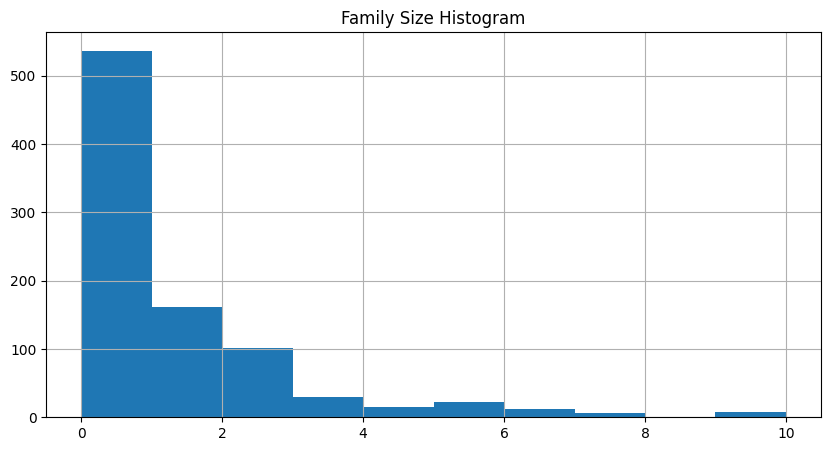

In [29]:
df_train['FamilySize'].hist()
plt.title('Family Size Histogram')

Plot a histogram of AgeFill segmented by Survived:

Text(0.5, 1.0, 'Survivors by Family Size')

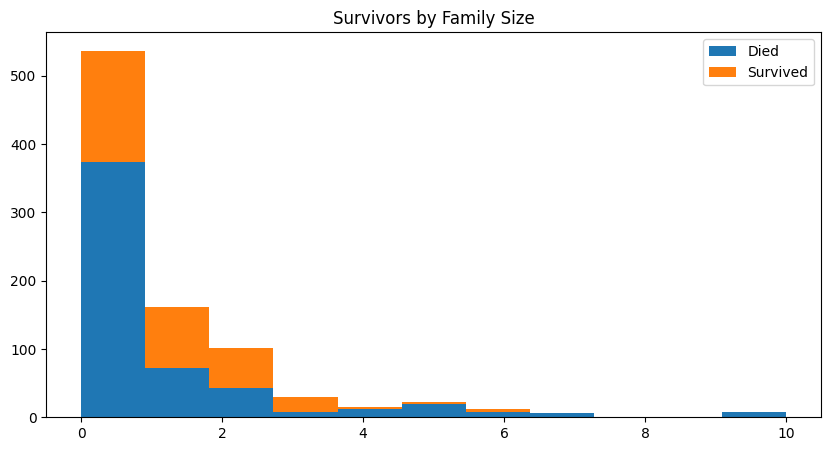

In [30]:
# Get the unique values of Embarked and its maximum
family_sizes = sorted(df_train['FamilySize'].unique())
family_size_max = max(family_sizes)

df1 = df_train[df_train['Survived'] == 0]['FamilySize']
df2 = df_train[df_train['Survived'] == 1]['FamilySize']
plt.hist([df1, df2], 
         bins=family_size_max + 1, 
         range=(0, family_size_max), 
         stacked=True)
plt.legend(('Died', 'Survived'), loc='best')
plt.title('Survivors by Family Size')

Based on the histograms, it is not immediately obvious what impact FamilySize has on survival.  The machine learning algorithms might benefit from this feature.

Additional features we might want to engineer might be related to the Name column, for example honorrary or pedestrian titles might give clues and better predictive power for a male's survival.

In [31]:
df_train.groupby(['Pclass', 'SibSp'])[['PassengerId','Survived','Age','Parch','Fare','FamilySize']].median()

PassengerId  Survived   Age  Parch      Fare  FamilySize
Pclass SibSp                                                          
1      0            476.0       1.0  37.0    0.0   39.6000         0.0
       1            485.0       1.0  38.0    0.0   79.2000         1.0
       2            572.0       1.0  44.0    0.0  133.6500         2.0
       3             89.0       1.0  23.0    2.0  263.0000         5.0
2      0            407.0       0.0  30.0    0.0   13.0000         0.0
       1            451.0       1.0  29.0    1.0   26.0000         2.0
       2            565.5       0.5  23.5    1.0   39.0000         3.0
       3            727.0       1.0  30.0    0.0   21.0000         3.0
3      0            472.0       0.0  26.0    0.0    7.8958         0.0
       1            372.0       0.0  25.0    0.0   15.5500         1.0
       2            334.0       0.0  19.5    0.0   19.2583         2.0
       3            302.5       0.0   6.0    1.0   25.4667         4.0
       4            264.5       0.0   6.5    1.5   31.2750         5.5
       5            387.0       0.0  11.0    2.0   46.9000         7.0
       8            325.0       0.0   NaN    2.0   69.5500        10.0

In [32]:
df_train.groupby(['Pclass', 'FamilySize'])[['PassengerId','Survived','Age','SibSp','Parch','Fare']].median()

PassengerId  Survived   Age  SibSp  Parch      Fare
Pclass FamilySize                                                     
1      0                 494.0       1.0  38.5    0.0    0.0   31.0000
       1                 389.0       1.0  37.0    1.0    0.0   76.7292
       2                 565.5       1.0  39.5    1.0    1.0   82.5083
       3                 436.0       1.0  14.0    1.0    2.0  120.0000
       4                 527.5       1.0  19.5    2.0    2.0  262.3750
       5                 215.5       0.5  23.5    3.0    2.0  263.0000
2      0                 399.5       0.0  31.0    0.0    0.0   13.0000
       1                 416.5       1.0  29.0    1.0    0.0   26.0000
       2                 507.0       1.0  22.0    1.0    1.0   26.2500
       3                 601.0       1.0  24.0    1.0    2.0   39.0000
       4                 775.0       1.0  54.0    1.0    3.0   23.0000
       5                 438.0       1.0  24.0    2.0    3.0   18.7500
3      0                 473.5       0.0  26.0    0.0    0.0    7.8958
       1                 372.0       0.0  24.5    1.0    0.0   14.4542
       2                 349.0       0.0  24.0    1.0    1.0   15.7417
       3                 645.0       1.0   5.0    1.0    2.0   19.2583
       4                 302.5       0.0  12.5    3.0    1.0   25.4667
       5                 361.0       0.0   8.0    4.0    1.0   29.1250
       6                 248.0       0.0   9.0    4.0    2.0   31.2750
       7                 434.0       0.0  12.5    5.0    2.0   46.9000
       10                325.0       0.0   NaN    8.0    2.0   69.5500

In [33]:
df_train.groupby(['Pclass', 'Parch'])[['PassengerId','Survived','Age','SibSp','Parch','Fare','FamilySize']].median()

PassengerId  Survived   Age  SibSp  Parch      Fare  FamilySize
Pclass Parch                                                                 
1      0            487.0       1.0  38.0    0.0    0.0   52.0000         0.0
       1            357.0       1.0  41.5    0.0    1.0   79.6500         1.0
       2            436.0       1.0  21.0    1.0    2.0  120.0000         3.0
       4            439.0       0.0  64.0    1.0    4.0  263.0000         5.0
2      0            403.0       0.0  30.0    0.0    0.0   13.0000         0.0
       1            540.5       1.0  23.5    1.0    1.0   26.2500         2.0
       2            462.0       1.0  23.0    0.5    2.0   27.7500         2.5
       3            606.5       1.0  39.0    1.5    3.0   20.8750         4.5
3      0            445.0       0.0  25.5    0.0    0.0    7.8958         0.0
       1            424.0       0.0  11.5    1.0    1.0   16.7000         2.0
       2            382.0       0.0   9.0    3.0    2.0   31.2750         5.0
       3            737.0       0.0  24.0    1.0    3.0   34.3750         4.0
       4            361.0       0.0  40.0    1.0    4.0   27.9000         5.0
       5            611.0       0.0  39.0    1.0    5.0   31.2750         6.0
       6            679.0       0.0  43.0    1.0    6.0   46.9000         7.0

In [34]:
train_grouped=df_train.groupby(['Pclass', 'Parch'])
df_train['Age'] = df_train['Age'].fillna(train_grouped['Age'].transform('median'))
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     891 non-null    object 
 12  FamilySize   891 non-null    int64  
dtypes: float64(2), int64(6), object(5)
memory usage: 90.6+ KB


In [35]:
df_train.groupby(['Pclass', 'FamilySize'])[['PassengerId','Survived','Age','SibSp','Parch','Fare']].median()

PassengerId  Survived   Age  SibSp  Parch      Fare
Pclass FamilySize                                                     
1      0                 494.0       1.0  38.0    0.0    0.0   31.0000
       1                 389.0       1.0  38.0    1.0    0.0   76.7292
       2                 565.5       1.0  39.5    1.0    1.0   82.5083
       3                 436.0       1.0  14.0    1.0    2.0  120.0000
       4                 527.5       1.0  19.5    2.0    2.0  262.3750
       5                 215.5       0.5  23.5    3.0    2.0  263.0000
2      0                 399.5       0.0  30.0    0.0    0.0   13.0000
       1                 416.5       1.0  29.0    1.0    0.0   26.0000
       2                 507.0       1.0  22.0    1.0    1.0   26.2500
       3                 601.0       1.0  24.0    1.0    2.0   39.0000
       4                 775.0       1.0  54.0    1.0    3.0   23.0000
       5                 438.0       1.0  24.0    2.0    3.0   18.7500
3      0                 473.5       0.0  25.5    0.0    0.0    7.8958
       1                 372.0       0.0  25.5    1.0    0.0   14.4542
       2                 349.0       0.0  20.0    1.0    1.0   15.7417
       3                 645.0       1.0   9.0    1.0    2.0   19.2583
       4                 302.5       0.0  11.5    3.0    1.0   25.4667
       5                 361.0       0.0   8.0    4.0    1.0   29.1250
       6                 248.0       0.0   9.0    4.0    2.0   31.2750
       7                 434.0       0.0  12.5    5.0    2.0   46.9000
       10                325.0       0.0   9.0    8.0    2.0   69.5500

# Imputing missing values in ``df_test``

In [36]:
df_test = pd.read_csv('test.csv')
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [37]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


Add the new column ``FamilySize``:

In [38]:
df_test['FamilySize'] = df_test['SibSp'] + df_test['Parch']

Similarly, we have missing values in columns ``Age`` and ``Cabin``. So we will impute the missing values in column ``Age`` following the same strategy we did in ``df_train``. 

In [39]:
df_test['Age'] = df_test['Age'].fillna(train_grouped['Age'].transform('median'))
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          418 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
 11  FamilySize   418 non-null    int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 39.3+ KB


## Final Data Preparation for Machine Learning

Many machine learning algorithms do not work on strings and they usually require the data to be in an array, not a DataFrame.

Show only the columns of type 'object' (strings):

In [40]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     891 non-null    object 
 12  FamilySize   891 non-null    int64  
dtypes: float64(2), int64(6), object(5)
memory usage: 90.6+ KB


Drop the columns we won't use:

In [41]:
df_train = df_train.drop(['Name', 'Ticket', 'Cabin'], axis=1)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Sex          891 non-null    object 
 4   Age          891 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Fare         891 non-null    float64
 8   Embarked     891 non-null    object 
 9   FamilySize   891 non-null    int64  
dtypes: float64(2), int64(6), object(2)
memory usage: 69.7+ KB


In [42]:
df_test = df_test.drop(['Name', 'Ticket', 'Cabin'], axis=1)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Sex          418 non-null    object 
 3   Age          418 non-null    float64
 4   SibSp        418 non-null    int64  
 5   Parch        418 non-null    int64  
 6   Fare         417 non-null    float64
 7   Embarked     418 non-null    object 
 8   FamilySize   418 non-null    int64  
dtypes: float64(2), int64(5), object(2)
memory usage: 29.5+ KB


Columns ``Sex`` and ``Embarked`` need to transform no numerical columns. 

<Axes: xlabel='Sex'>

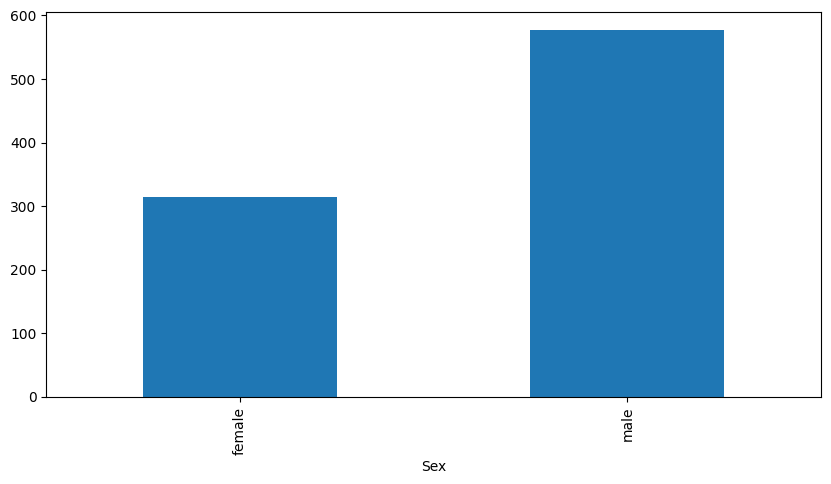

In [43]:
df_train.groupby('Sex').count()['PassengerId'].plot(kind = 'bar')

The frequenct class in column ``Sex`` is male, so we map 'male' to 1 and 'female' to 0.  

In [44]:
df_train['Sex'] = df_train['Sex'].map({'male':1, 'female':0}).astype(int)
df_test['Sex'] = df_test['Sex'].map({'male':1, 'female':0}).astype(int)

We replace the column ``Embarked`` with a one-hot-vector of length 3. 

In [45]:
cols = pd.get_dummies(df_train['Embarked'], prefix= 'Embarked')
df_train[cols.columns] = cols
df_train.drop('Embarked', axis = 1, inplace = True)

In [46]:
cols = pd.get_dummies(df_test['Embarked'], prefix= 'Embarked')
df_test[cols.columns] = cols
df_test.drop('Embarked', axis = 1, inplace = True)

In [47]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Sex          891 non-null    int64  
 4   Age          891 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Fare         891 non-null    float64
 8   FamilySize   891 non-null    int64  
 9   Embarked_C   891 non-null    bool   
 10  Embarked_Q   891 non-null    bool   
 11  Embarked_S   891 non-null    bool   
dtypes: bool(3), float64(2), int64(7)
memory usage: 65.4 KB


Also, we can drop the two columns ``SibSp`` and ``Parch`` and only keep the new column ``FamilySize`` as a representation of the family size. 

In [48]:
df_train.drop(['SibSp', 'Parch'], axis = 1, inplace = True)
df_test.drop(['SibSp', 'Parch'], axis = 1, inplace = True)

Final inspection of the ``df_test`` shows that column ``Fare``, has a missing value. 

In [49]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Sex          418 non-null    int64  
 3   Age          418 non-null    float64
 4   Fare         417 non-null    float64
 5   FamilySize   418 non-null    int64  
 6   Embarked_C   418 non-null    bool   
 7   Embarked_Q   418 non-null    bool   
 8   Embarked_S   418 non-null    bool   
dtypes: bool(3), float64(2), int64(4)
memory usage: 20.9 KB


In [50]:
df_train[['Survived', 'Fare']].groupby('Survived').mean()

,Fare
Survived,
0,22.117887
1,48.395408


The average Fare for passenger who survived the incident is higher than the other group. Hence, there should be a meaningful relationship between ``Pclass`` and ``Fare``. 

In [51]:
df_train[['Pclass', 'Fare']].groupby('Pclass').mean()

,Fare
Pclass,
1,84.154687
2,20.662183
3,13.675550


In [52]:
df_test['Fare'] = df_test['Fare'].fillna(df_train.groupby('Pclass')['Fare'].transform('mean'))
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Sex          418 non-null    int64  
 3   Age          418 non-null    float64
 4   Fare         418 non-null    float64
 5   FamilySize   418 non-null    int64  
 6   Embarked_C   418 non-null    bool   
 7   Embarked_Q   418 non-null    bool   
 8   Embarked_S   418 non-null    bool   
dtypes: bool(3), float64(2), int64(4)
memory usage: 20.9 KB


In [53]:
df_train.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,FamilySize,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,1,22.0,7.2500,1,False,False,True
1,2,1,1,0,38.0,71.2833,1,True,False,False
2,3,1,3,0,26.0,7.9250,0,False,False,True
3,4,1,1,0,35.0,53.1000,1,False,False,True
4,5,0,3,1,35.0,8.0500,0,False,False,True


## KNN: Training

In [54]:
X = df_train.drop('Survived', axis = 1)
y = df_train['Survived']

First split and scale the ``df_train``:

In [55]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train_org, X_test_org, y_train, y_test = train_test_split(X, y, random_state = 0)

In [56]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_org)
X_test = scaler.transform(X_test_org)
df_test_scaled = scaler.transform(df_test)

In [57]:
df_test_scaled

array([[ 1.71722938,  0.83012938,  0.72705166, ..., -0.45841567,
         3.1832897 , -1.67196129],
       [ 1.72107891,  0.83012938, -1.37541808, ..., -0.45841567,
        -0.31414043,  0.59809997],
       [ 1.72492843, -0.36497068,  0.72705166, ..., -0.45841567,
         3.1832897 , -1.67196129],
       ...,
       [ 3.31478339,  0.83012938,  0.72705166, ..., -0.45841567,
        -0.31414043,  0.59809997],
       [ 3.31863292,  0.83012938,  0.72705166, ..., -0.45841567,
        -0.31414043,  0.59809997],
       [ 3.32248245,  0.83012938,  0.72705166, ...,  2.1814263 ,
        -0.31414043, -1.67196129]])

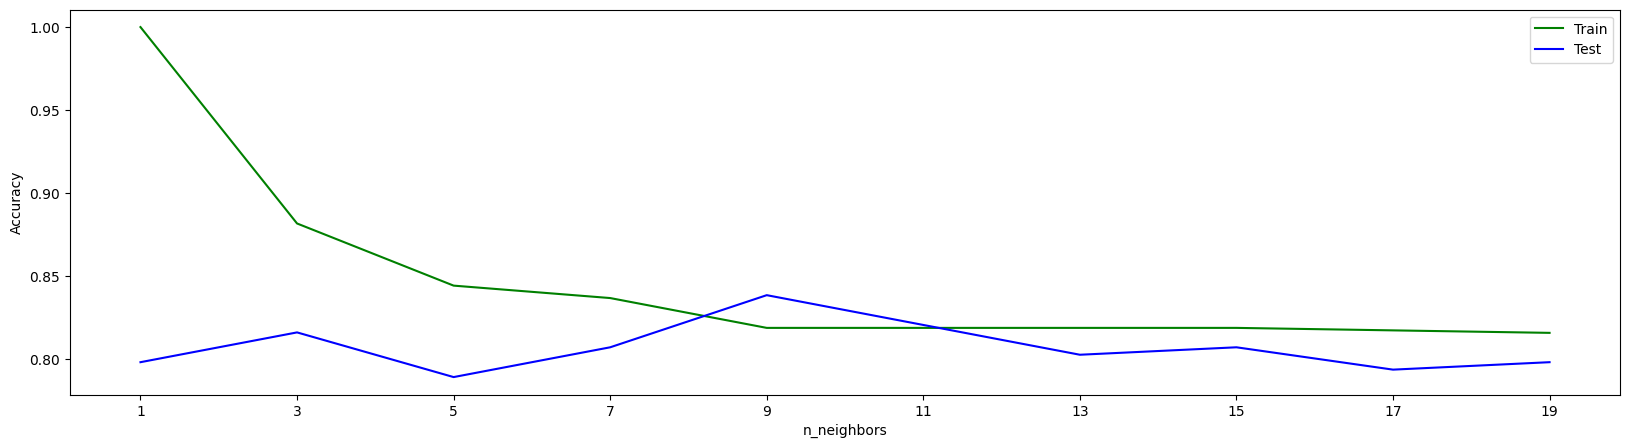

In [58]:
%matplotlib inline
from sklearn.neighbors import KNeighborsClassifier

train_array = []
test_array = []
x_axis = range(1,20,2)

#We will generate only odd number of neighbors to avoid ties
for k in range(1,20,2):
    knn=KNeighborsClassifier(n_neighbors = k)   
    knn.fit(X_train,y_train)
    train_score=knn.score(X_train,y_train)
    test_score=knn.score(X_test,y_test)
    train_array.append(train_score)
    test_array.append(test_score)

plt.subplots(figsize = (20,5))
plt.plot(x_axis, train_array, c='g', label = 'Train')
plt.plot(x_axis, test_array, c='b', label = 'Test')
plt.xticks(x_axis, range(1,20,2))
plt.xlabel('n_neighbors')
plt.ylabel('Accuracy')
plt.legend()

In [59]:
knn=KNeighborsClassifier(n_neighbors = 9)
knn.fit(X_train, y_train)
print('Train score: %.4f'%knn.score(X_train, y_train))
print('Test score: %.4f'%knn.score(X_test, y_test))

Train score: 0.8189
Test score: 0.8386


## Final Prediction

In [60]:
final_test_prediction = knn.predict(df_test_scaled)

By using Python built-in function `help()` we can get documentation string of the function or class method. This is helpful when we are trying to save time to look up the documentation. 

In [61]:
help(knn.score)

Help on method score in module sklearn.base:

score(X, y, sample_weight=None) method of sklearn.neighbors._classification.KNeighborsClassifier instance
    Return the mean accuracy on the given test data and labels.
    
    In multi-label classification, this is the subset accuracy
    which is a harsh metric since you require for each sample that
    each label set be correctly predicted.
    
    Parameters
    ----------
    X : array-like of shape (n_samples, n_features)
        Test samples.
    
    y : array-like of shape (n_samples,) or (n_samples, n_outputs)
        True labels for `X`.
    
    sample_weight : array-like of shape (n_samples,), default=None
        Sample weights.
    
    Returns
    -------
    score : float
        Mean accuracy of ``self.predict(X)`` w.r.t. `y`.

